In [1]:
import pandas as pd
import spacy
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


import sys
sys.path.append("../..")
from util.vis import t_sne, pca
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../../data/04-0c_Test_Set.pkl')

# SpaCy Vectors

SpaCy enables the creating vector representations for sequences. Those are visualized and evaluated here as a first baseline.

% TODO: - Look up model and ensure that meaning is included

Only the test set is used to have a reduced number of authors and enable better visualization. In the end, this will be comparable to the evaluation of the test set with the final model.

In [3]:
nlp = spacy.load("en_core_web_sm")

messages = test_data["message"].tolist()

vectors = []

docs = nlp.pipe(messages)

for doc in tqdm(docs):
    vectors.append(doc.vector)

10684it [00:27, 389.88it/s]


## Centroids

In [4]:
authors_centroids = {}

vectors = np.array(vectors)

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [5]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,1.110,1.377,1.676,1.528,1.115,1.743
1,0.000,0.000,1.224,1.628,1.374,1.223,1.245
2,0.000,0.000,0.000,1.713,1.445,1.095,1.503
3,0.000,0.000,0.000,0.000,2.569,2.063,2.449
4,0.000,0.000,0.000,0.000,0.000,1.315,0.983
5,0.000,0.000,0.000,0.000,0.000,0.000,1.455
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

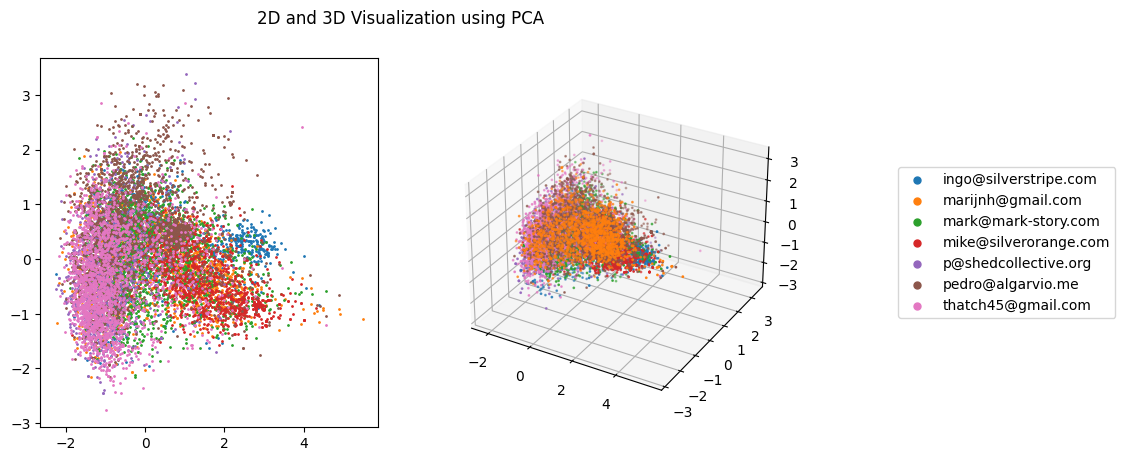

In [6]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

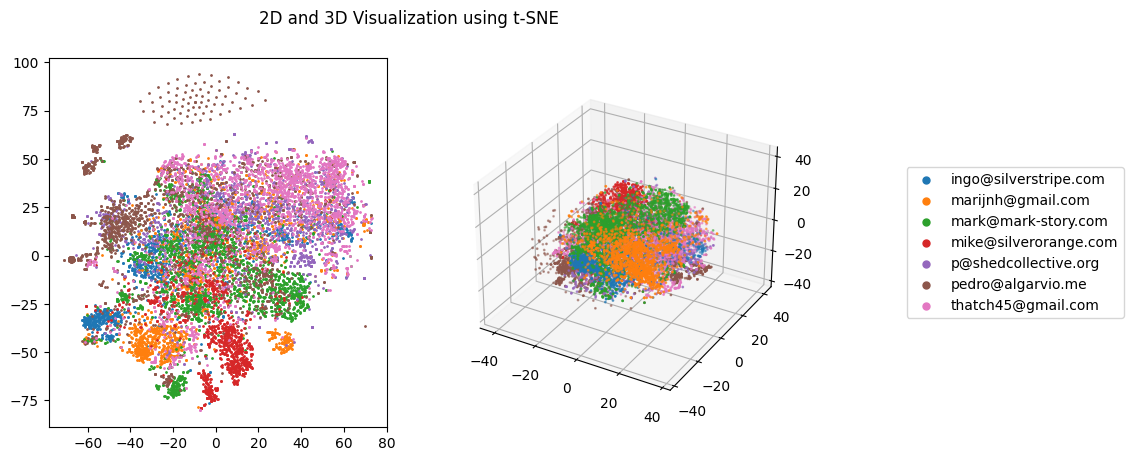

In [7]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

It can be seen that many SpaCy representations are similar and might be difficult to cluster. 

Anyways, below we try a density-based DBSCAN clustering and a centroid-based K-Means clustering to see if we can find clusters in the data.

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 5
10 Most common:
[(-1, 6060), (0, 4237), (1, 240), (2, 76), (3, 71)]


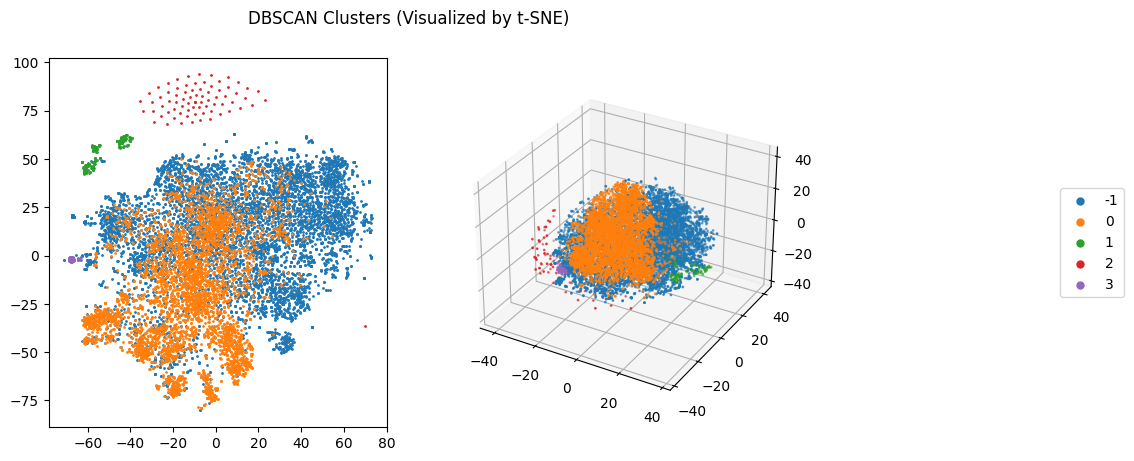

In [8]:
dbscan_model = DBSCAN(eps=2, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [9]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,6060.0,7.0,998.0,"('thatch45@gmail.com', 1674)",84.0,7.0,"('saltstack_salt', 2814)"
1,4237.0,7.0,638.0,"('mark@mark-story.com', 1051)",62.0,4.0,"('silverorange_swat', 1014)"
2,240.0,1.0,240.0,"('pedro@algarvio.me', 240)",1.0,240.0,"('saltstack_salt', 240)"
3,76.0,1.0,76.0,"('pedro@algarvio.me', 76)",1.0,76.0,"('saltstack_salt', 76)"
4,71.0,1.0,71.0,"('pedro@algarvio.me', 71)",1.0,71.0,"('saltstack_salt', 71)"


In [10]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2136.800000,3.400000,404.600000,29.800000,79.600000
std,2824.651076,3.286335,404.029454,40.195771,95.918194
min,71.000000,1.000000,71.000000,1.000000,4.000000
25%,76.000000,1.000000,76.000000,1.000000,7.000000
50%,240.000000,1.000000,240.000000,1.000000,71.000000
75%,4237.000000,7.000000,638.000000,62.000000,76.000000
max,6060.000000,7.000000,998.000000,84.000000,240.000000


In [11]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4
length_mean,49.884158,116.365117,51.825000,54.197368,50.887324
length_std,18.254177,72.558760,8.630047,0.973595,5.628272
n_uppercase_mean,2.237624,5.748407,2.000000,6.000000,1.014085
n_uppercase_std,2.885717,5.348506,0.000000,0.000000,0.205074
polarity_mean,0.011315,0.015461,0.000000,0.000000,-0.001408
polarity_std,0.178608,0.188462,0.000000,0.000000,0.011784
subjectivity_mean,0.165561,0.246296,0.000000,0.000000,0.007042
subjectivity_std,0.273729,0.293232,0.000000,0.000000,0.058920


In [12]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
Allowing success and error callbacks in refresh()
___
3) 
Better shell execution feedback from PDF extractor
___
4) 
Added iShouldSeeAButton assertion
___
5) 
MINOR Avoid reinitialising tabs (see #<I>)
___
6) 
Calling destructor on fatal errors

Avoids leaving TESTS_RUNNING.js around
___
7) 
MINOR Removed unnecessary 'actionsparams' class from LeftAndMain forms
___
8) 
Added getters for http client/response
___
9) 
BUGFIX Making HTML5 History support optional, so we can disable HTML4 hash change fallback
___
10) 
FIX Unset "underneath page" title when switching to "top" in "add page"
_________________

Number of messages in this class: 6060
Most common author:
('thatch45@gmail.com', 1674)
Most common project:
('saltstack_salt', 2814)



________________ Class 1 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no 

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(4, 2573), (1, 2346), (6, 1997), (2, 1448), (3, 1021), (0, 1020), (5, 279)]


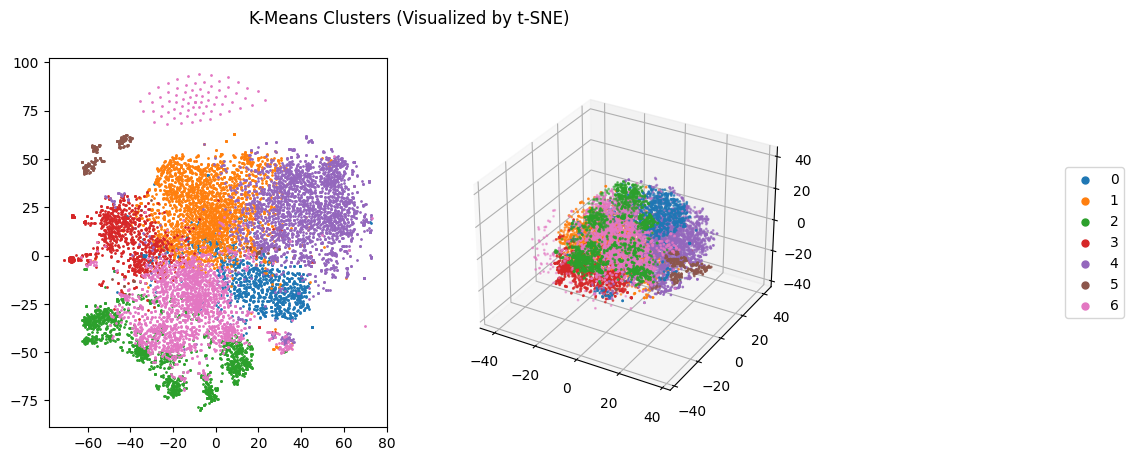

In [13]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [14]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,1020.0,7.0,32.0,"('mark@mark-story.com', 737)",39.0,2.0,"('cakephp_cakephp', 676)"
1,2346.0,7.0,305.0,"('thatch45@gmail.com', 583)",73.0,3.0,"('saltstack_salt', 1012)"
2,1448.0,7.0,209.0,"('mike@silverorange.com', 567)",32.0,2.0,"('silverorange_swat', 567)"
3,1021.0,7.0,93.0,"('pedro@algarvio.me', 525)",52.0,2.0,"('saltstack_salt', 531)"
4,2573.0,7.0,216.0,"('thatch45@gmail.com', 1111)",60.0,4.5,"('saltstack_salt', 1298)"
5,279.0,6.0,6.5,"('pedro@algarvio.me', 247)",12.0,1.5,"('saltstack_salt', 251)"
6,1997.0,7.0,196.0,"('marijnh@gmail.com', 539)",45.0,2.0,"('silverorange_swat', 446)"


In [15]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.857143,151.071429,44.714286,2.428571
std,822.861210,0.377964,109.342897,19.796585,1.017700
min,279.000000,6.000000,6.500000,12.000000,1.500000
25%,1020.500000,7.000000,62.500000,35.500000,2.000000
50%,1448.000000,7.000000,196.000000,45.000000,2.000000
75%,2171.500000,7.000000,212.500000,56.000000,2.500000
max,2573.000000,7.000000,305.000000,73.000000,4.500000


In [16]:
clustering_spacy_evaluation(kmeans_prediction, test_data)

,0,1,2,3,4,5,6
length_mean,55.164706,90.326513,85.148481,73.378061,50.009328,52.605735,103.038558
length_std,29.302953,66.523640,75.393430,53.742868,22.713681,14.043536,60.794992
n_uppercase_mean,2.301961,2.889173,6.287983,4.242899,2.214924,2.304659,5.017026
n_uppercase_std,2.109037,3.703020,6.387083,5.193396,3.092947,2.092060,3.981141
polarity_mean,-0.001617,0.017442,0.016348,0.002384,0.010430,0.001523,0.020700
polarity_std,0.193578,0.209686,0.158459,0.168170,0.164544,0.030082,0.182952
subjectivity_mean,0.164394,0.272567,0.142359,0.181942,0.146560,0.003584,0.235472
subjectivity_std,0.264243,0.309061,0.256072,0.273216,0.255072,0.036731,0.297302


In [17]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Fix AssetAdmin::$allowed_actions
___
2) 
MINOR Making HTTPTest less fragile around global state. Improved test readability.
___
3) 
Consistent sorting for getDiffList()

If changes were applied in the same second (e.g. through tests), the results will have an indeterminate order.
This lead to stability issues in VersionFeedFunctionalTest::testContainsChangesForPageOnly.
Sort by ID in addition to LastEdited.
___
4) 
Fixed 'receipt_email' configuration

Was trying to access an undeclared static.
Changed to configuration API.
___
5) 
Disable a search test on Phantom

Due to unexplainable hanging.
___
6) 
Safeguard against IE6/7 event access exceptions.
___
7) 
Move 'use strict' inside of main function

To prevent problems with script concatenation.
___
8) 
Update some doc comments.

Add references to guides.
___
9) 
Set hr tags to non-editable

This appears to solve the flaky cursor-crossing behavior.
___
10) 
Finish mapping overhaul. Te